# Tasks

* Implement vanilla autoencoder
* Train it on MNIST dataset MNIST
* Display digits recovered dy AE
* Display distribution of embeddings in latent space

#Dataset

http://yann.lecun.com/exdb/mnist/

The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples.

The images were centered in a 28x28 image by computing the center of mass of the pixels.



In [ ]:
import torch, torchvision
from torchvision.datasets import MNIST
from torchvision import transforms, utils


transf = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize( (0.1307) , (0.3081) )
                             ])

train_dataset = MNIST('mnist',
                      train = True,
                      download = True,
                      transform = transf
                      )

test_dataset = MNIST('mnist',
                     train = False,
                     download = True,
                     transform = transf
                     )

100%|██████████| 9912422/9912422 [00:00<00:00, 288197858.36it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6748130.68it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6984732.92it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3242643.19it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Display some samples along with corresponding labels

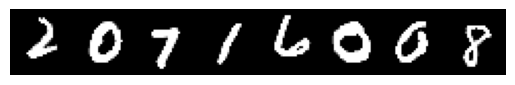

[2 0 7 1 6 0 0 8]


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import  DataLoader

# Helper method
def show(grid):
  plt.axis("off")
  plt.imshow(grid.permute(1,2,0).numpy())
  plt.show()

vis_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle=True)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter) # img1,  label

# display the data
grid = torchvision.utils.make_grid(example_batch[0])
show(grid)
print(example_batch[1].numpy())

In [ ]:
x = torch.tensor([0., 1, 2, 3, 4, 5, 6, 7])
unfl = torch.nn.Unflatten(0, (-1, 2, 2, 2))
x = unfl(x)
print(x)
convTr = torch.nn.ConvTranspose2d(2, 4, (3,3), stride=3, padding=2)

x = convTr(x)
print(x)
print(x.size())

tensor([[[[0., 1.],
          [2., 3.]],

         [[4., 5.],
          [6., 7.]]]])
tensor([[[[ 0.5533, -0.0651],
          [ 0.9004, -0.1455]],

         [[ 0.3205, -0.4951],
          [ 0.6874, -1.6360]],

         [[-0.1089,  0.5991],
          [-0.0454,  0.3599]],

         [[-0.5833, -0.6234],
          [-0.1046,  0.8898]]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 4, 2, 2])


# Model

Implement vanilla autoencoder model.

In [ ]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_size, c1=40, c2=200, l1=500):
      super().__init__()
      self.latent_size = latent_size

      # Put your code here
      self.seq = nn.Sequential(
          nn.Conv2d(1, c1, (3,3), padding=1),
          nn.MaxPool2d(2),
          nn.ReLU(),
          nn.Conv2d(c1, c2, (3,3), padding=1),
          nn.MaxPool2d(2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(c2*7*7, l1),
          nn.ReLU(),
          nn.Linear(l1, latent_size)
      )

    def forward(self,x):

      # Put your code here
      embedding = self.seq(x)
      return embedding


class Decoder(nn.Module):
    def __init__(self, latent_size, c1=40, c2=200, l1=500):
      super().__init__()
      self.latent_size = latent_size

      # Put your code here
      self.seq = nn.Sequential(
          nn.Linear(latent_size, l1),
          nn.ReLU(),
          nn.Linear(l1, c2*7*7),
          nn.Unflatten(1, (c2, 7, 7)),
          nn.ReLU(),
          nn.ConvTranspose2d(c2, c1, (4,4), stride=2, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(c1, 1, (4,4), stride=2, padding=1)
      )


    def forward(self,x):

      # Put your code here
      recovered = self.seq(x)
      return recovered

##Smoke test

In [ ]:
encoder = Encoder(2)
dummy = torch.randn((1,1,28,28))
print("Encoder In",dummy.shape)
embedding = encoder(dummy)
print("encoder Out",embedding.shape)


decoder =Decoder(2)
recovered = decoder(embedding)
print("Decoder out",recovered.shape)

assert( dummy.shape == recovered.shape) ,"Decoder out shape must be equal to input shape"

Encoder In torch.Size([1, 1, 28, 28])
encoder Out torch.Size([1, 2])
Decoder out torch.Size([1, 1, 28, 28])


###AE

Implement AutoEncoder class.
Use Decoder and Encoder classes implemented early.

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()

    # Put your code here
    self.encoder = Encoder(latent_size)
    self.decoder = Decoder(latent_size)

  def forward(self,x):
    # Put your code here
    embedding = self.encoder(x)
    recovered_x = self.decoder(embedding)
    return recovered_x, embedding

# Train

Define dataloaders

In [ ]:
train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=128)
test_dataloader = DataLoader(test_dataset,shuffle=False,batch_size=256)

In [ ]:
print(train_dataloader.__len__())

469


Define main training routine and train your model

In [ ]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Put your code here
model = AutoEncoder(2)
model.to(device)

criterion = nn.MSELoss()

lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(20):
  model.train()
  for i, (img_batch, labels_batch) in enumerate(train_dataloader):
    recovered_imgs, embeddings = model(img_batch.to(device))
    loss = criterion(recovered_imgs.cpu(), img_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  model.eval()

  print("Epoch {}: Loss {:.4f}".format(epoch, loss.item()))




Epoch 0: Loss 0.5123
Epoch 1: Loss 0.4397
Epoch 2: Loss 0.3757
Epoch 3: Loss 0.4094
Epoch 4: Loss 0.4133
Epoch 5: Loss 0.3622
Epoch 6: Loss 0.4034
Epoch 7: Loss 0.4166
Epoch 8: Loss 0.4098
Epoch 9: Loss 0.3948
Epoch 10: Loss 0.3693
Epoch 11: Loss 0.3868
Epoch 12: Loss 0.3740
Epoch 13: Loss 0.3845
Epoch 14: Loss 0.3792
Epoch 15: Loss 0.3579
Epoch 16: Loss 0.3942
Epoch 17: Loss 0.3512
Epoch 18: Loss 0.3717
Epoch 19: Loss 0.3624


## Let's test the model

Compare original and recovered digits.

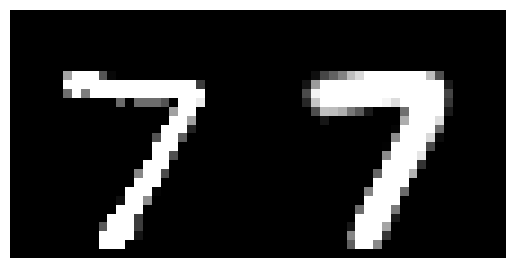

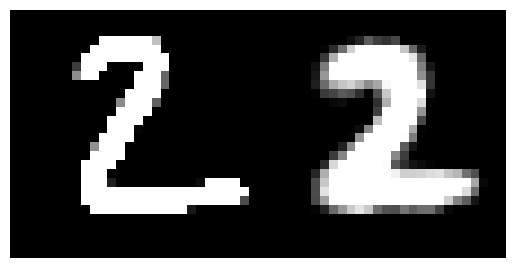

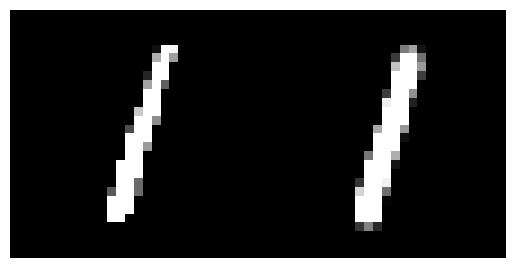

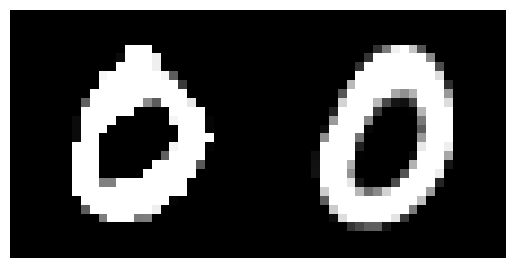

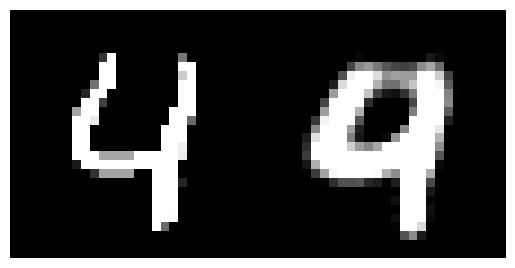

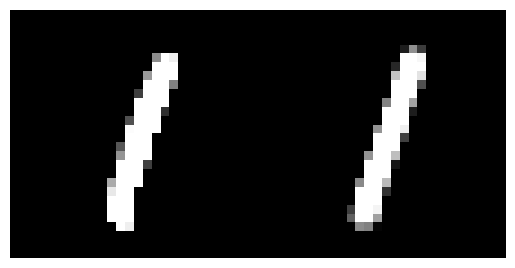

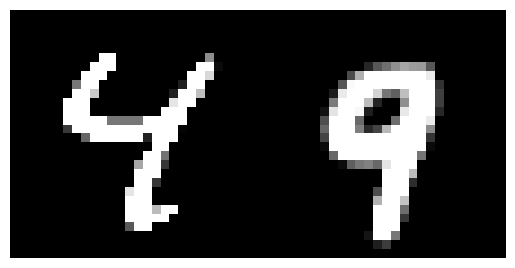

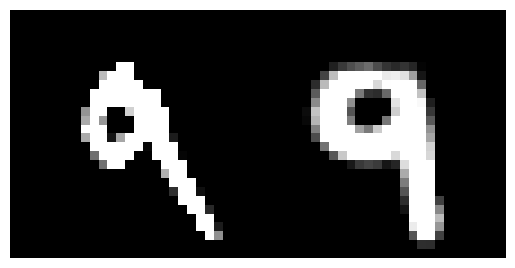

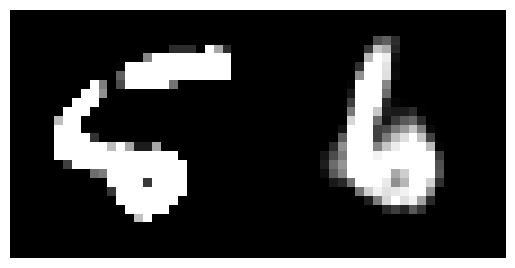

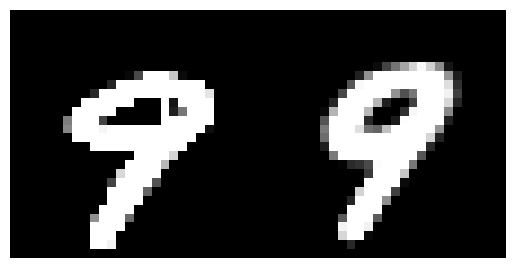

In [ ]:
# put your code here
from torchvision.utils import make_grid

for i in range(10):
  img, label = test_dataset[i]
  recovered_img, embedding = model(img.unsqueeze(0).to(device))
  with torch.no_grad():
    grid = make_grid(torch.cat([img, recovered_img[0].cpu()], 2))
    show(grid)


Show embeddings positions in latent space

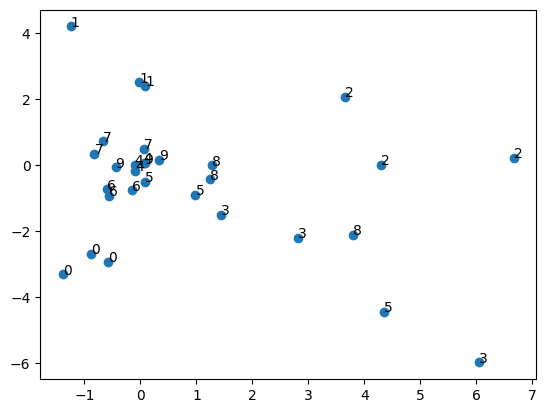

In [ ]:
# put your code here

xs = []
ys = []
labels = []
digits = {i: 0 for i in range(10)}
k = 3
for img, label in test_dataset:
  if digits[label] == k:
    continue
  digits[label] += 1

  recovered_img, embedding = model(img.unsqueeze(0).to(device))
  xs.append(embedding.cpu()[0][0].item())
  ys.append(embedding.cpu()[0][1].item())
  labels.append(label)

  if (sum(digits.values()) == 10 * k):
    break

plt.scatter(xs, ys)
for i, label in enumerate(labels):
  plt.annotate(f"{label}", (xs[i], ys[i]), fontsize=10)



# Conclusion

Видно, что восстановленные изображения очень похожи на оригинальные, но при этом на "скрытом пространстве" векторы не столь различимы


# Ideas for extra work

* Find the best latent space size
* Implement noise filtration with AE
* Test vector arithmetic in laent space
* Implemet VAE
** Use Autoencoder class as base class
** Implement VAE Loss class
** Plot embeddings manifold in VAE latent space
** Compare decoding results VAE latent space with vanilla Autoencoder results
* Replace reconstruction loss from MSE to BCE
* Implement Conditional Autoencoder or CVAE

In [ ]:

class DigitsDataset():

  def __init__(self, ds):
    self.ds = ds
    self.pos = {d: 0 for d in range(10)}

  def __getitem__(self, i):
    return self.ds[i]

  def next(self, d):
    while self.pos[d] < len(self.ds) and self.ds[self.pos[d]][1] != d:
      self.pos[d] += 1
    if self.pos[d] == len(self.ds):
      raise StopIteration
    img = self.ds[self.pos[d]][0]
    self.pos[d] += 1
    return img

In [ ]:
digits = DigitsDataset(test_dataset)


Чем выше размерность скрытого пространства, тем меньше MSE

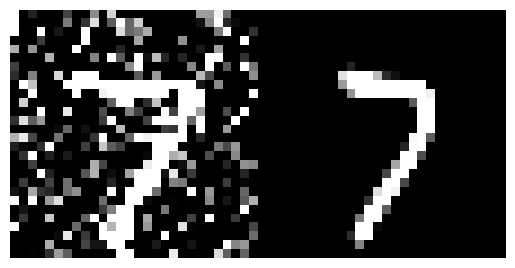

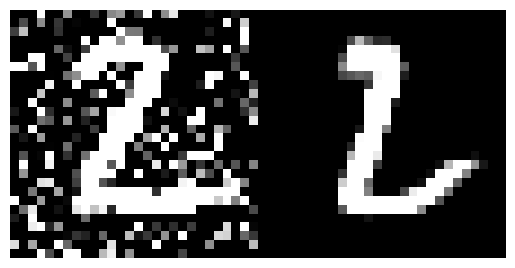

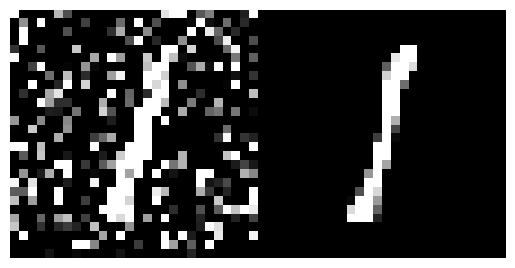

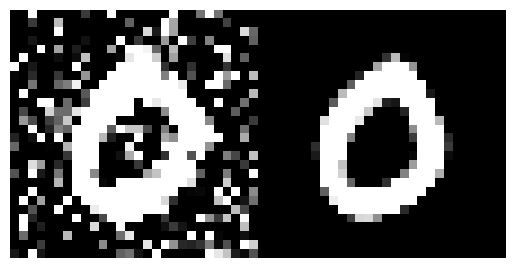

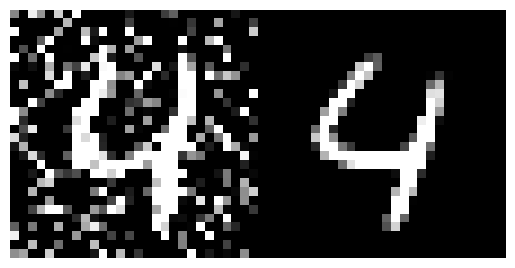

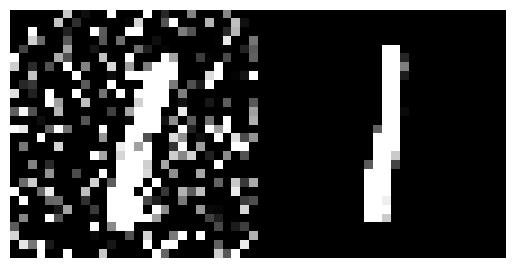

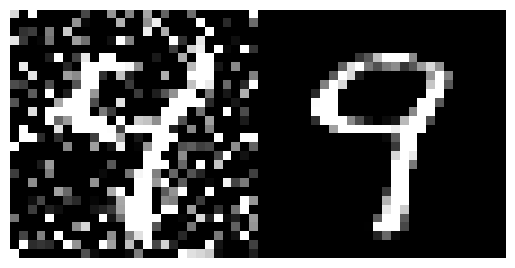

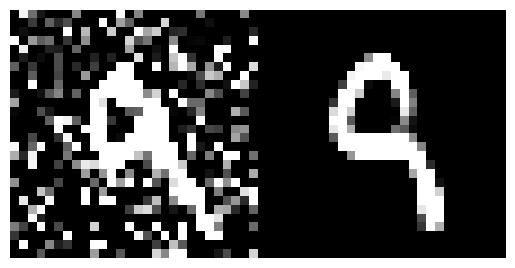

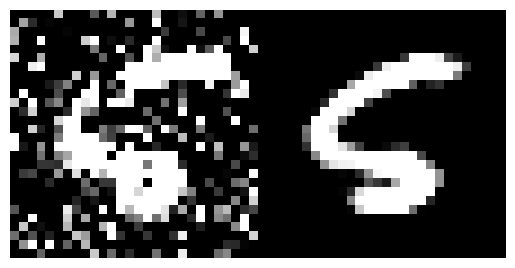

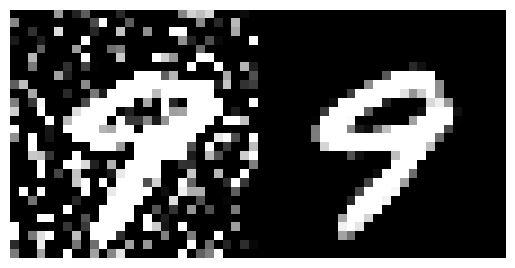

In [ ]:
# noise filtration

def add_noize(img):
  noize = torch.randn_like(img,)
  return img + noize

for i in range(10):
  img, label = digits[i]
  img = add_noize(img)
  recovered_img, _ = model(img.unsqueeze(0).to(device))
  with torch.no_grad():
    show(make_grid(torch.cat([img, recovered_img[0].cpu()], 2)))

Видно, что автоэнкодер неплохо справляется с удалением шума

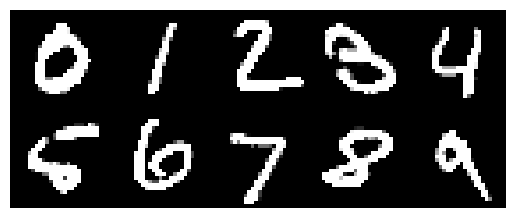

expected 2:


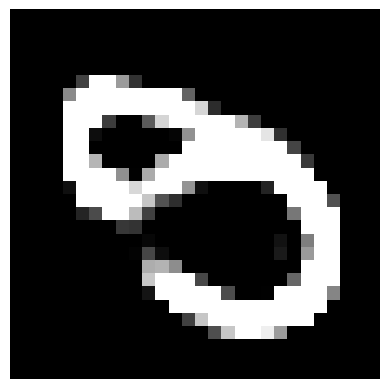

expected 1:


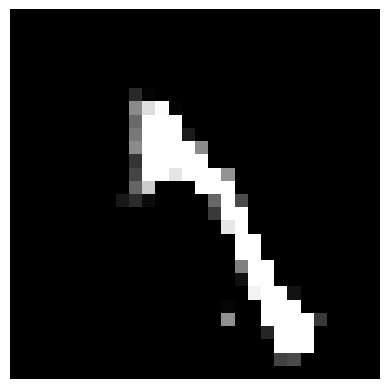

expected 5:


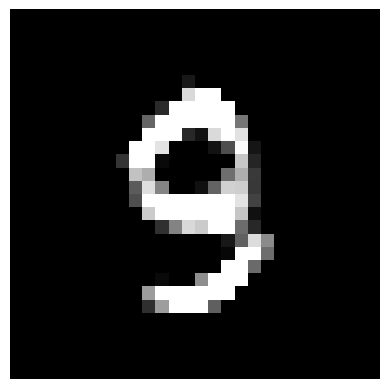

In [ ]:
# vector arithmetic in latent space

img0 = digits.next(0)
img1 = digits.next(1)
img2 = digits.next(2)
img3 = digits.next(3)
img4 = digits.next(4)
img5 = digits.next(5)
img6 = digits.next(6)
img7 = digits.next(7)
img8 = digits.next(8)
img9 = digits.next(9)

show(make_grid(torch.cat([torch.cat([img0, img1, img2, img3, img4], dim=2),
                         torch.cat([img5, img6, img7, img8, img9], dim=2)], dim=1)))

embedding0 = model.encoder(img0.unsqueeze(0).to(device))
embedding1 = model.encoder(img1.unsqueeze(0).to(device))
embedding2 = model.encoder(img2.unsqueeze(0).to(device))
embedding3 = model.encoder(img3.unsqueeze(0).to(device))
embedding4 = model.encoder(img4.unsqueeze(0).to(device))
embedding5 = model.encoder(img5.unsqueeze(0).to(device))
embedding6 = model.encoder(img6.unsqueeze(0).to(device))
embedding7 = model.encoder(img7.unsqueeze(0).to(device))
embedding8 = model.encoder(img8.unsqueeze(0).to(device))
embedding9 = model.encoder(img9.unsqueeze(0).to(device))

dif_3_1 = embedding3 - embedding1
img_expected_2 = model.decoder(dif_3_1)
print('expected 2:')

show(make_grid(img_expected_2[0].cpu()))

dif_9_8 = embedding9 - embedding8
img_expected_1 = model.decoder(dif_9_8)
print('expected 1:')
show(make_grid(img_expected_1[0].cpu()))

dif_8_3 = embedding8 - embedding8
img_expected_5 = model.decoder(dif_8_3)
print('expected 5:')
show(make_grid(img_expected_5[0].cpu()))


Как видно, векторная арифметика в скрытом пространстве совсем не работает, как могло бы подуматься

In [ ]:
import torch

torch.zeros_like(torch.tensor([0., 1., 2.]))

tensor([0., 0., 0.])

In [ ]:
# VAE
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F

class VAE(AutoEncoder):

  def __init__(self, latent_size):
    super().__init__(latent_size)
    self.mu_extractor = nn.Linear(latent_size, latent_size)
    self.sigma_extractor = nn.Linear(latent_size, latent_size)

  def forward(self, x):
    embedding = self.encoder(x)
    mu = self.mu_extractor(embedding)
    sigma = self.sigma_extractor(embedding)
    distr = MultivariateNormal(mu, torch.diag_embed(sigma**2))
    z = distr.rsample()
    x_recovered = self.decoder(z)
    return x_recovered, embedding, mu, sigma


class VAELoss(nn.Module):

  def __init__(self, kld_weight=0.05):
    super().__init__()
    self.kld_weight = kld_weight

  def forward(self, x, x_recovered, mu, sigma):
    mse = F.mse_loss(x, x_recovered)
    kld = 0.5 * torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1, dim=1)
    kld = kld.mean()
    return mse + self.kld_weight * kld, mse, kld


In [ ]:
model_vae = VAE(2)
model_vae.to(device)

criterion = VAELoss()

optimizer = optim.Adam(model_vae.parameters(), lr=5e-4)

for epoch in range(20):
  model_vae.train()
  for i, (img_batch, labels_batch) in enumerate(train_dataloader):
    img_recovered, embedding, mu, sigma = model_vae(img_batch.to(device))
    loss, mse, kld = criterion(img_batch, img_recovered.cpu(), mu, sigma)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  model_vae.eval()

  print("Epoch {}: Loss={:.4f}, MSE={:.4f}, KLD={:.4f}".format(epoch, loss.item(), mse.item(), kld.item()))

Epoch 0: Loss=0.6848, MSE=0.6438, KLD=0.8203
Epoch 1: Loss=0.6906, MSE=0.6470, KLD=0.8721
Epoch 2: Loss=0.6638, MSE=0.6121, KLD=1.0332
Epoch 3: Loss=0.6954, MSE=0.6433, KLD=1.0416
Epoch 4: Loss=0.6930, MSE=0.6354, KLD=1.1518
Epoch 5: Loss=0.6890, MSE=0.6269, KLD=1.2428
Epoch 6: Loss=0.6830, MSE=0.6227, KLD=1.2063
Epoch 7: Loss=0.6374, MSE=0.5692, KLD=1.3639
Epoch 8: Loss=0.6497, MSE=0.5709, KLD=1.5757
Epoch 9: Loss=0.6846, MSE=0.6172, KLD=1.3486
Epoch 10: Loss=0.6913, MSE=0.6104, KLD=1.6168
Epoch 11: Loss=0.6579, MSE=0.5816, KLD=1.5274
Epoch 12: Loss=0.6675, MSE=0.5918, KLD=1.5135
Epoch 13: Loss=0.6351, MSE=0.5491, KLD=1.7214
Epoch 14: Loss=0.6529, MSE=0.5669, KLD=1.7204
Epoch 15: Loss=0.6049, MSE=0.5174, KLD=1.7502
Epoch 16: Loss=0.6379, MSE=0.5389, KLD=1.9811
Epoch 17: Loss=0.6261, MSE=0.5367, KLD=1.7896
Epoch 18: Loss=0.6648, MSE=0.5781, KLD=1.7358
Epoch 19: Loss=0.6495, MSE=0.5540, KLD=1.9114


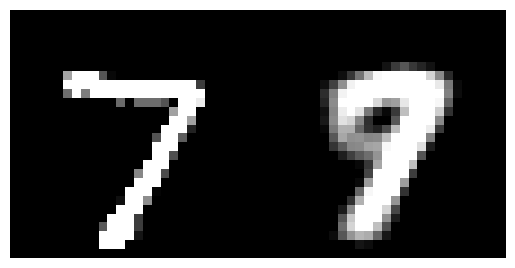

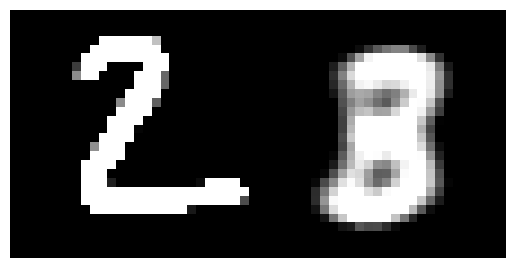

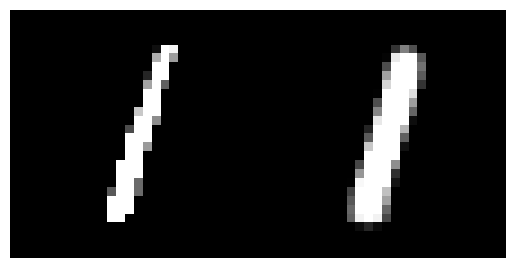

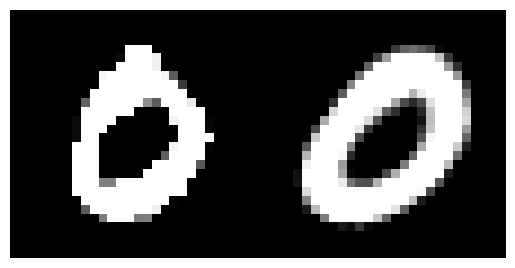

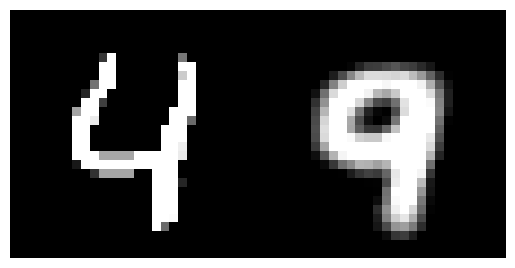

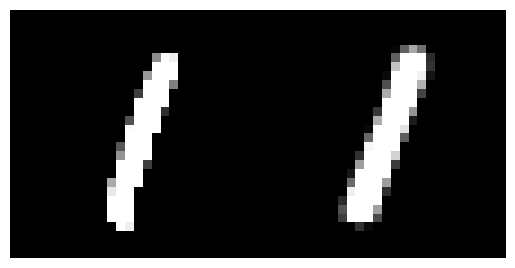

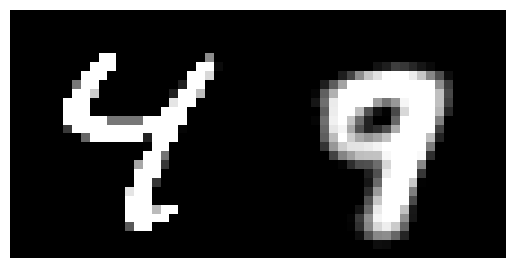

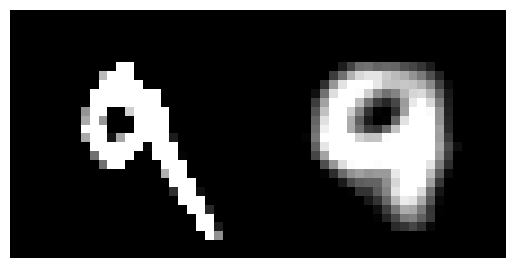

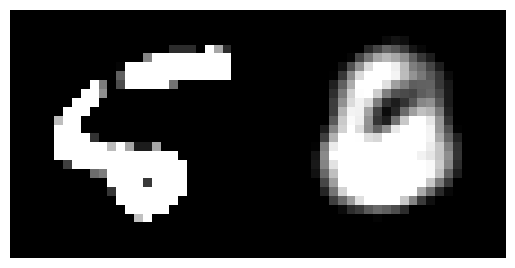

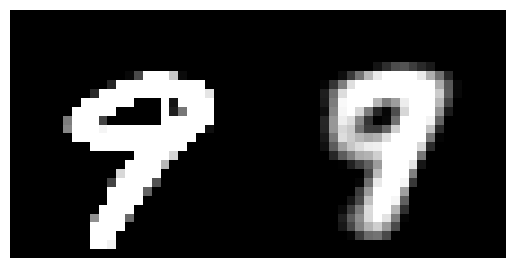

In [ ]:
for i in range(10):
  img, label = test_dataset[i]
  img_recovered, embedding, _, _ = model_vae(img.unsqueeze(0).to(device))
  with torch.no_grad():
    show(make_grid(torch.cat([img, img_recovered[0].cpu()], 2)))

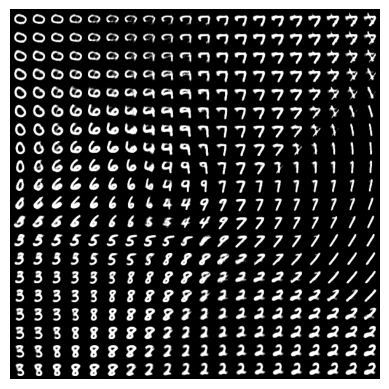

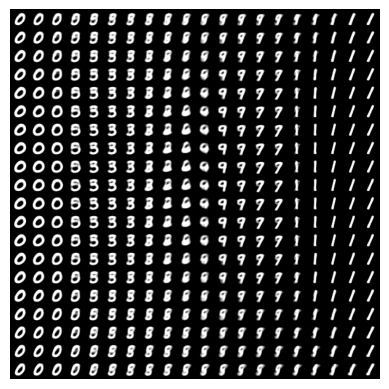

In [ ]:

embedding = torch.cartesian_prod(torch.linspace(-3., 3., 20), torch.linspace(-2, 2, 20))
x_recovered = model.decoder(embedding.to(device))
x_recovered_vae = model_vae.decoder(embedding.to(device))

fig = plt.gcf()
with torch.no_grad():
  show(make_grid(x_recovered.cpu(), 20))
  show(make_grid(x_recovered_vae.cpu(), 20))
